In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d koryakinp/fingers
!unzip fingers.zip

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class DataSplitting(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.transform = transform
        self.img_paths = []

        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    self.img_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path)

        label = int(os.path.basename(img_path).split('.')[0][-2:-1])

        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
import torchvision.transforms as transforms
from collections import Counter
from torch.utils.data import random_split
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the dataset from the train and test folders.
train_dataset = DataSplitting(path='/content/fingers/train', transform=transform)
test_dataset = DataSplitting(path='/content/fingers/test', transform=transform)

# Creating the split size.
train_size=int(0.7*len(train_dataset))
val_size=int(0.3*len(train_dataset))
# Splitting the dataset into validation and training datatset.
val_dataset, train_dataset = random_split(train_dataset, [val_size, train_size])

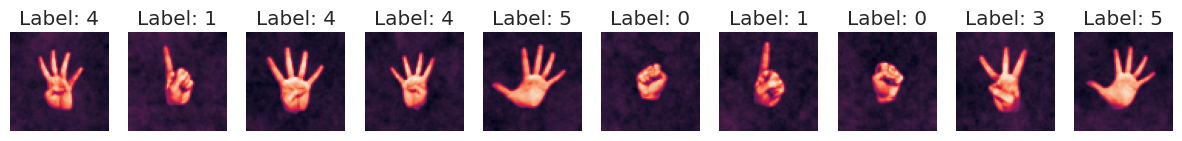

In [ ]:
# Checking the if the images have been given a valid label.
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 10, figsize=(15, 3))

for i in range(10):
    image, label = train_dataset1[i]
    axes[i].imshow(image.squeeze())
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()

In [ ]:
#Splitting the DataLoader for train. validation and test set.
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
#Convolution Layer with 3 conv2d layers, 2 pooling layers and 3 activation layers.
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self, inputDims):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(int(inputDims[0]/4)*int(inputDims[1]/4)*128 ,256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 6),
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        #flatten
        x = x.view(-1, 128*32*32)
        # fc layer
        x = self.fc_layer(x)
        return x



In [ ]:
import torch.optim as optim
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN((128,128)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs=5

In [ ]:
import torch
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):

        inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):

            inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(val_loader)}], Val Loss: {loss.item():.4f}')

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

print('Training complete')

Epoch [1/5], Batch [1/197], Train Loss: 1.7929
Epoch [1/5], Batch [2/197], Train Loss: 3.6280
Epoch [1/5], Batch [3/197], Train Loss: 3.3242
Epoch [1/5], Batch [4/197], Train Loss: 2.0246
Epoch [1/5], Batch [5/197], Train Loss: 1.8618
Epoch [1/5], Batch [6/197], Train Loss: 1.7583
Epoch [1/5], Batch [7/197], Train Loss: 1.7523
Epoch [1/5], Batch [8/197], Train Loss: 1.7307
Epoch [1/5], Batch [9/197], Train Loss: 1.7233
Epoch [1/5], Batch [10/197], Train Loss: 1.7481
Epoch [1/5], Batch [11/197], Train Loss: 1.6077
Epoch [1/5], Batch [12/197], Train Loss: 1.5809
Epoch [1/5], Batch [13/197], Train Loss: 1.4580
Epoch [1/5], Batch [14/197], Train Loss: 1.3037
Epoch [1/5], Batch [15/197], Train Loss: 1.2650
Epoch [1/5], Batch [16/197], Train Loss: 1.1372
Epoch [1/5], Batch [17/197], Train Loss: 0.8994
Epoch [1/5], Batch [18/197], Train Loss: 0.7968
Epoch [1/5], Batch [19/197], Train Loss: 0.6230
Epoch [1/5], Batch [20/197], Train Loss: 0.4168
Epoch [1/5], Batch [21/197], Train Loss: 0.4172
E

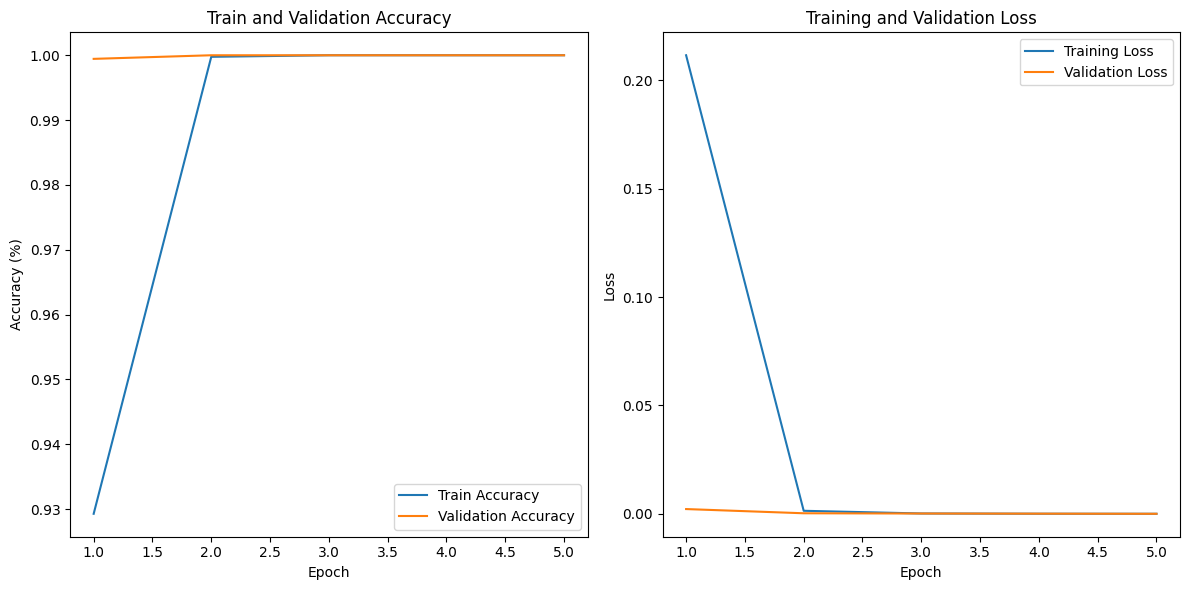

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


Test Accuracy: 0.9997222222222222
Test Recall: 0.9997222222222222


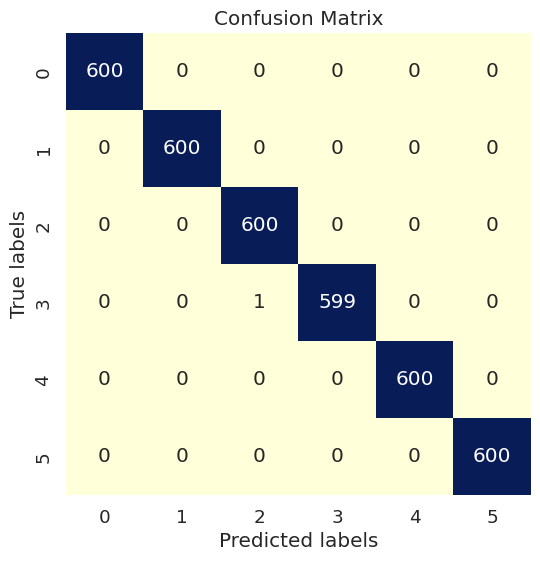

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import seaborn as sns

def eval_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print('Test Accuracy:', accuracy)
    print('Test Recall:', recall)

    plt.figure(figsize=(6, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

eval_model(model, test_loader)


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class DataSplitting2(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.img_paths = []


        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    self.img_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path)

        label = (os.path.basename(img_path).split('.')[0][-2:])
        classnames=['0L','0R','1L','1R','2L','2R','3L','3R','4L','4R','5L','5R']

        if self.transform:
            image = self.transform(image)

        return image, classnames.index(label)


In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import random_split
from collections import Counter
transform2 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
# Load the dataset from the train and test folders.
train_dataset2 = DataSplitting2(path='/content/fingers/train', transform=transform2)
test_dataset2 = DataSplitting2(path='/content/fingers/test', transform=transform2)

# Creating the split size.
train_size2=int(0.7*len(train_dataset2))
val_size2=int(0.3*len(train_dataset2))
# Splitting the dataset into validation and training datatset.
val_dataset2, train_dataset2 = random_split(train_dataset2, [val_size2, train_size2])

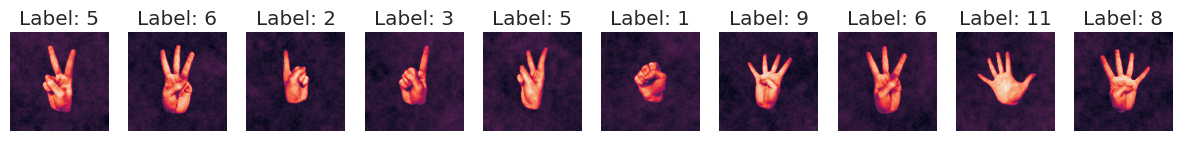

In [ ]:
#Labels of images from 0 to 11(for 12 different classes)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 10, figsize=(15, 3))

for i in range(10):
    image, label = train_dataset2[i]
    axes[i].imshow(image.squeeze())
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()

In [ ]:
from torch.utils.data import DataLoader
train_loader2 = DataLoader(train_dataset2, batch_size=64, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=64, shuffle=False)
val_loader2 = DataLoader(val_dataset2, batch_size=64, shuffle=False)

In [ ]:
import torch.optim as optim
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN(nn.Module):
    def __init__(self, inputDims):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(int(inputDims[0]/2)*int(inputDims[1]/2)*128 ,256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 12),
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(-1, int(x.size(1)*x.size(2)*x.size(3)))
        # fc layer
        x = self.fc_layer(x)
        return x




In [ ]:
import torch.optim as optim
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN((128,128)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs=6


In [ ]:
import torch
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader2):

        inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_loader2.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader2):

            inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(val_loader2)}], Val Loss: {loss.item():.4f}')

    val_loss /= len(val_loader2.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

print('Training complete')

Epoch [1/6], Batch [1/197], Train Loss: 2.4782
Epoch [1/6], Batch [2/197], Train Loss: 17.5477
Epoch [1/6], Batch [3/197], Train Loss: 4.4440
Epoch [1/6], Batch [4/197], Train Loss: 3.3056
Epoch [1/6], Batch [5/197], Train Loss: 2.7329
Epoch [1/6], Batch [6/197], Train Loss: 2.5294
Epoch [1/6], Batch [7/197], Train Loss: 2.4726
Epoch [1/6], Batch [8/197], Train Loss: 2.4495
Epoch [1/6], Batch [9/197], Train Loss: 2.3720
Epoch [1/6], Batch [10/197], Train Loss: 2.2927
Epoch [1/6], Batch [11/197], Train Loss: 2.0862
Epoch [1/6], Batch [12/197], Train Loss: 2.3218
Epoch [1/6], Batch [13/197], Train Loss: 1.8231
Epoch [1/6], Batch [14/197], Train Loss: 1.7283
Epoch [1/6], Batch [15/197], Train Loss: 1.6299
Epoch [1/6], Batch [16/197], Train Loss: 1.1718
Epoch [1/6], Batch [17/197], Train Loss: 0.9339
Epoch [1/6], Batch [18/197], Train Loss: 0.6949
Epoch [1/6], Batch [19/197], Train Loss: 0.5972
Epoch [1/6], Batch [20/197], Train Loss: 0.5841
Epoch [1/6], Batch [21/197], Train Loss: 0.4655


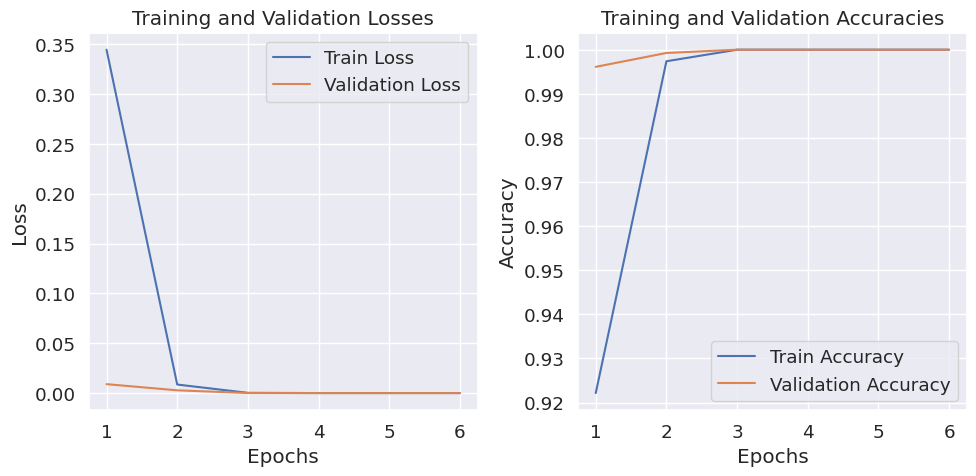

In [ ]:
import matplotlib.pyplot as plt

# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Test Accuracy-2: 1.0
Test Recall-2: 1.0


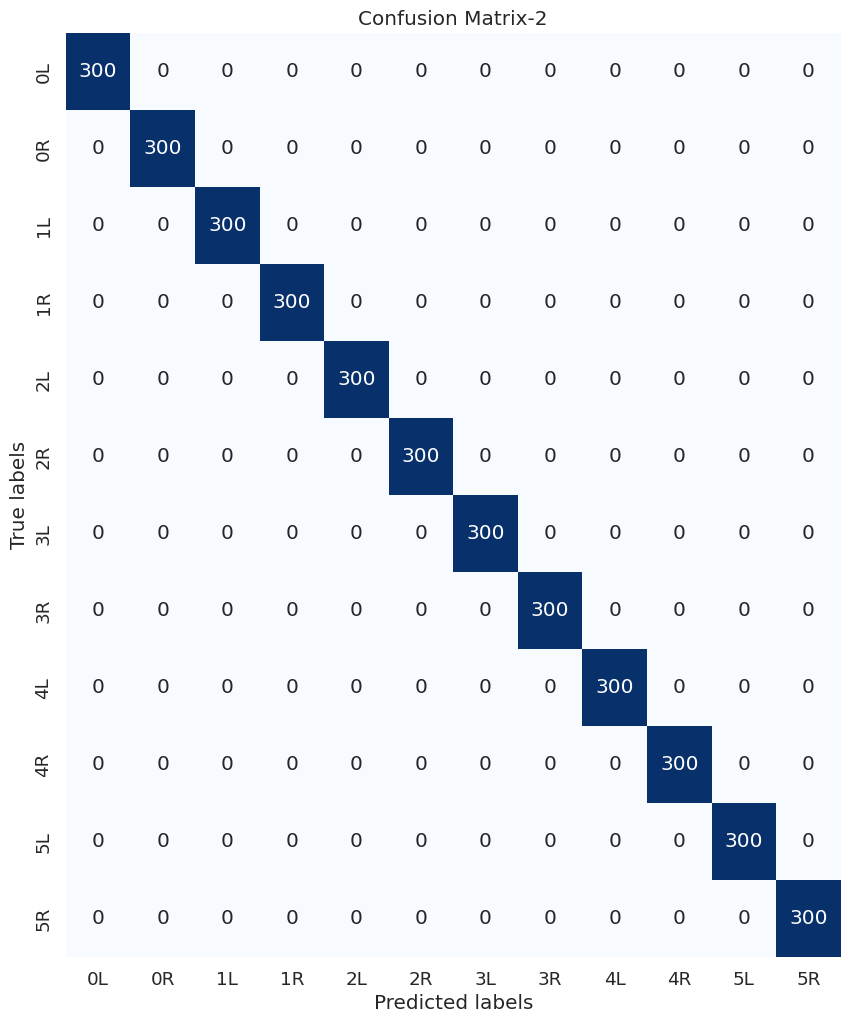

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import numpy as np
import seaborn as sns
import pandas as pd
def evaluate_model(model, test_loader):
    model.eval()
    y_true2 = []
    y_pred2 = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true2.extend(labels.cpu().numpy())
            y_pred2.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true2, y_pred2)
    recall = recall_score(y_true2, y_pred2, average='macro')
    conf_matrix = confusion_matrix(y_true2, y_pred2)

    print('Test Accuracy-2:', accuracy)
    print('Test Recall-2:', recall)


    conf_matrix = confusion_matrix(y_true2, y_pred2)

    class_names = ['0L','0R','1L','1R','2L','2R','3L','3R','4L','4R','5L','5R']


    plt.figure(figsize=(10, 12))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix-2')
    plt.show()


evaluate_model(model, test_loader2)

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class DataSplitting3(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.img_paths = []


        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    self.img_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = (os.path.basename(img_path).split('.')[0][-2:])
        classnames=['0L','0R','1L','1R','2L','2R','3L','3R','4L','4R','5L','5R']

        if self.transform:
            image = self.transform(image)

        return image, classnames.index(label)


In [ ]:
import torchvision.transforms as transforms
from collections import Counter
from torch.utils.data import random_split
import torch

transform3 = transforms.Compose([
    #Resizing to 224*224 as the default input size for the resnet architecture expects a image of size 224*224.
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the dataset from the train and test folders.
train_dataset3 = DataSplitting3(path='/content/fingers/train', transform=transform2)
test_dataset3 = DataSplitting3(path='/content/fingers/test', transform=transform2)

# Creating the split size.
train_size3=int(0.7*len(train_dataset3))
val_size3=int(0.3*len(train_dataset3))
# Splitting the dataset into validation and training datatset.
val_dataset3, train_dataset3 = random_split(train_dataset3, [val_size3, train_size3])

In [ ]:
from torch.utils.data import DataLoader

train_loader3 = DataLoader(train_dataset3, batch_size=64, shuffle=True)
test_loader3 = DataLoader(test_dataset3, batch_size=64, shuffle=False)
val_loader3 = DataLoader(val_dataset3, batch_size=64, shuffle=False)

In [ ]:
import torch.optim as optim
import torchvision.models as models
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Using resnet18 and setting parameter pretrained as False.
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
num_classes = 12
#Setting the Linear layer to predict 12 output classes.
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs=5
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader3):

        inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader3)}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_loader3.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader3):

            inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(val_loader3)}], Val Loss: {loss.item():.4f}')

    val_loss /= len(val_loader3.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

print('Training complete')

Epoch [1/5], Batch [1/197], Train Loss: 2.6163
Epoch [1/5], Batch [2/197], Train Loss: 1.7662
Epoch [1/5], Batch [3/197], Train Loss: 1.2910
Epoch [1/5], Batch [4/197], Train Loss: 1.0515
Epoch [1/5], Batch [5/197], Train Loss: 0.6679
Epoch [1/5], Batch [6/197], Train Loss: 0.4198
Epoch [1/5], Batch [7/197], Train Loss: 0.1589
Epoch [1/5], Batch [8/197], Train Loss: 0.1999
Epoch [1/5], Batch [9/197], Train Loss: 0.0965
Epoch [1/5], Batch [10/197], Train Loss: 0.2936
Epoch [1/5], Batch [11/197], Train Loss: 0.1201
Epoch [1/5], Batch [12/197], Train Loss: 0.1301
Epoch [1/5], Batch [13/197], Train Loss: 0.0662
Epoch [1/5], Batch [14/197], Train Loss: 0.0466
Epoch [1/5], Batch [15/197], Train Loss: 0.0733
Epoch [1/5], Batch [16/197], Train Loss: 0.1257
Epoch [1/5], Batch [17/197], Train Loss: 0.0584
Epoch [1/5], Batch [18/197], Train Loss: 0.1052
Epoch [1/5], Batch [19/197], Train Loss: 0.1284
Epoch [1/5], Batch [20/197], Train Loss: 0.0363
Epoch [1/5], Batch [21/197], Train Loss: 0.1321
E

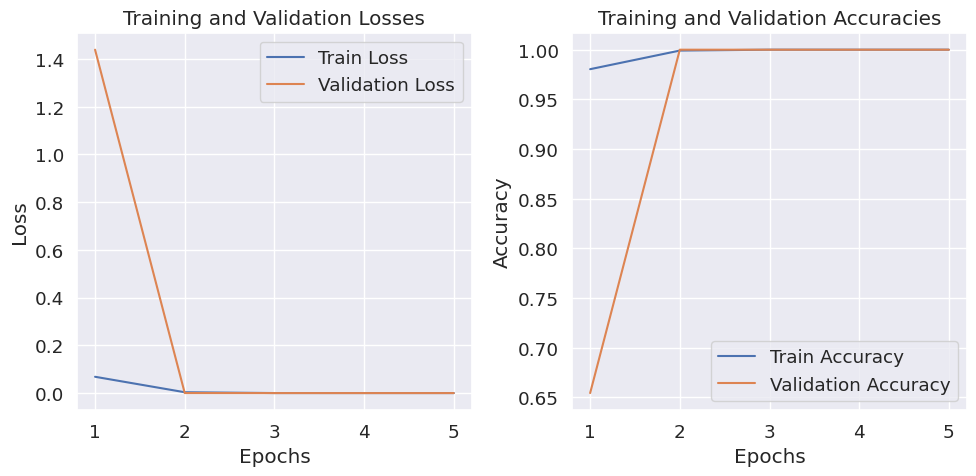

In [ ]:
import matplotlib.pyplot as plt

# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Test Accuracy-3: 1.0
Test Recall-3: 1.0


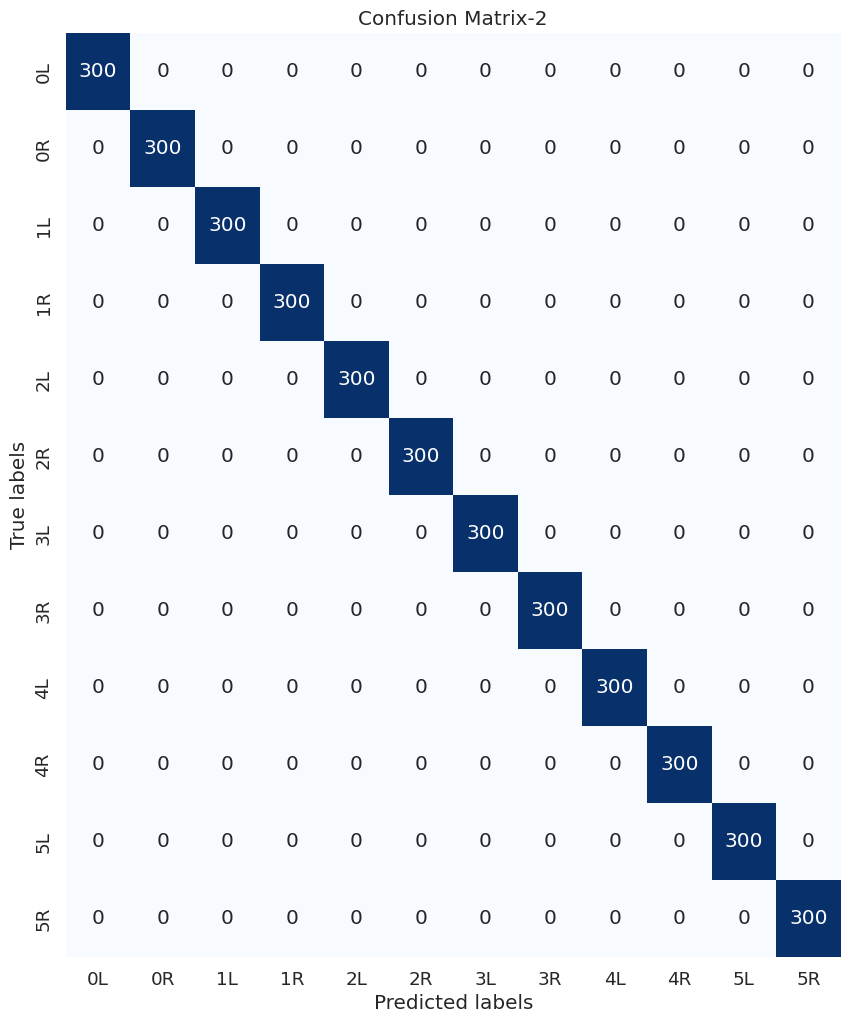

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import numpy as np
import seaborn as sns
import pandas as pd
def evaluate_model(model, test_loader):
    model.eval()
    y_true3 = []
    y_pred3 = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true3.extend(labels.cpu().numpy())
            y_pred3.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true3, y_pred3)
    recall = recall_score(y_true3, y_pred3, average='macro')
    conf_matrix = confusion_matrix(y_true3, y_pred3)

    print('Test Accuracy-3:', accuracy)
    print('Test Recall-3:', recall)


    conf_matrix = confusion_matrix(y_true3, y_pred3)

    class_names = ['0L','0R','1L','1R','2L','2R','3L','3R','4L','4R','5L','5R']


    plt.figure(figsize=(10, 12))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix-2')
    plt.show()


evaluate_model(model, test_loader3)

In [ ]:
import torch.optim as optim
import torchvision.models as models
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Using the pre-defined ResNet18 with transfer learning.
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features

num_classes = 12

model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader3):

        inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader3)}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_loader3.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader3):

            inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(val_loader3)}], Val Loss: {loss.item():.4f}')

    val_loss /= len(val_loader3.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

print('Training complete')

Epoch [1/5], Batch [1/197], Train Loss: 2.9280
Epoch [1/5], Batch [2/197], Train Loss: 1.5361
Epoch [1/5], Batch [3/197], Train Loss: 0.6013
Epoch [1/5], Batch [4/197], Train Loss: 0.2026
Epoch [1/5], Batch [5/197], Train Loss: 0.2032
Epoch [1/5], Batch [6/197], Train Loss: 0.1233
Epoch [1/5], Batch [7/197], Train Loss: 0.1603
Epoch [1/5], Batch [8/197], Train Loss: 0.1316
Epoch [1/5], Batch [9/197], Train Loss: 0.0263
Epoch [1/5], Batch [10/197], Train Loss: 0.0604
Epoch [1/5], Batch [11/197], Train Loss: 0.0340
Epoch [1/5], Batch [12/197], Train Loss: 0.0301
Epoch [1/5], Batch [13/197], Train Loss: 0.0093
Epoch [1/5], Batch [14/197], Train Loss: 0.0160
Epoch [1/5], Batch [15/197], Train Loss: 0.0789
Epoch [1/5], Batch [16/197], Train Loss: 0.0034
Epoch [1/5], Batch [17/197], Train Loss: 0.0928
Epoch [1/5], Batch [18/197], Train Loss: 0.0198
Epoch [1/5], Batch [19/197], Train Loss: 0.0098
Epoch [1/5], Batch [20/197], Train Loss: 0.0055
Epoch [1/5], Batch [21/197], Train Loss: 0.0201
E

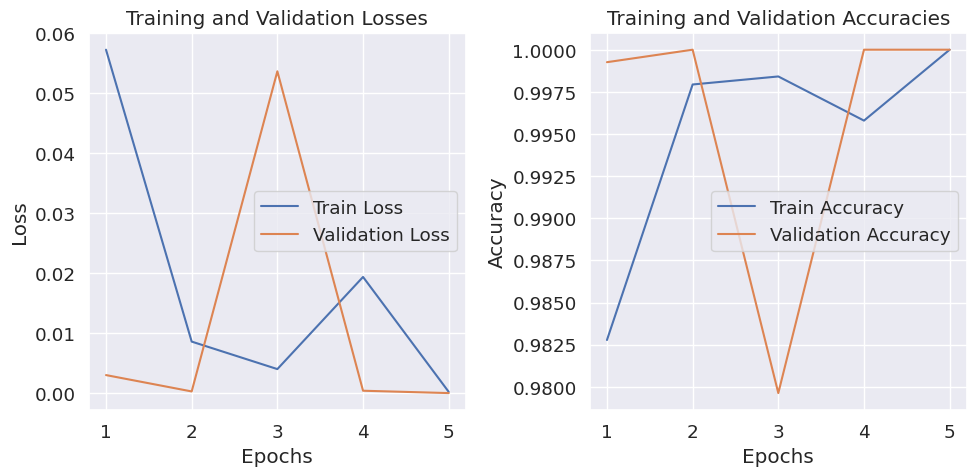

In [ ]:
import matplotlib.pyplot as plt

# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Test Accuracy-3: 1.0
Test Recall-3: 1.0


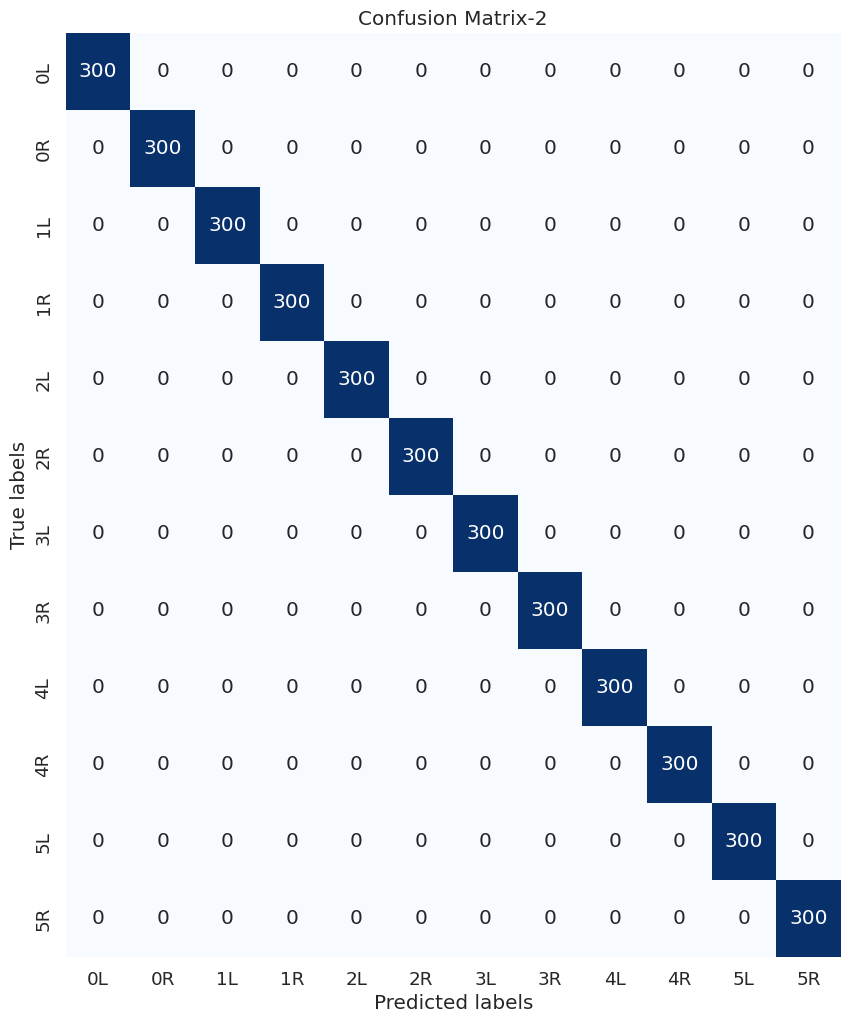

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import numpy as np
import seaborn as sns
import pandas as pd
def evaluate_model(model, test_loader):
    model.eval()
    y_true3 = []
    y_pred3 = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true3.extend(labels.cpu().numpy())
            y_pred3.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true3, y_pred3)
    recall = recall_score(y_true3, y_pred3, average='macro')
    conf_matrix = confusion_matrix(y_true3, y_pred3)
    conf_matrix = confusion_matrix(y_true3, y_pred3)
    class_names = ['0L','0R','1L','1R','2L','2R','3L','3R','4L','4R','5L','5R']


    plt.figure(figsize=(10, 12))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix-2')
    plt.show()


evaluate_model(model, test_loader3)